### <span style="color:#FFD000">Drugs: cocain, crack | Runtime: 1 hour 30 minutes</span>

# <span style="color:#1477d2">Imports</span>

In [1]:
import time

START_TIMER = time.time()


In [2]:
# Standard library imports
import gc
import json
import os

# Third-party imports
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, precision_recall_curve, recall_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score


# <span style="color:#1477d2">Constants and help functions</span>

In [3]:
INPUT_DATA_PATH = '../data/clean_NSDUH_2015-2019_V2.parquet'
MODELS_PATH = '../models/'
os.makedirs(MODELS_PATH, exist_ok=True)
NUMERICAL_COLUMNS = [    # Continuous variables
    'iralcfy',           # Number of days alcohol was consumed in the past year
    'irmjfy',            # Number of days marijuana was used in the past year
    'cig30use',          # Number of days cigarettes were smoked in the past month
    'irherfy',           # Number of days heroin was used in the past year
    'irmethamyfq',       # Number of days methamphetamine was used in the past year
    'wrkdhrswk2',        # Number of hours worked in the past week
    'irki17_2',          # Number of children under 18 years old in the household
    'irhhsiz2',          # Number of people in the household
]
CATEGORICAL_COLUMNS = [  # Categorical variables
    'newrace2',          # Race or ethnicity of the respondent
    'irsex',             # Sex of the respondent
    'catag3',            # Age group of the respondent
    'health',            # General health condition of the respondent
    'ireduhighst2',      # Highest level of education completed
    'irpinc3',           # Income range of the household
]


In [4]:
def clear_memory():
    gc.collect()


# <span style="color:#1477d2">Data preprocessing</span>

Перш ніж ми зможемо використовувати наші дані для навчання моделей, нам потрібно зробити кілька речей:
1. Вибрати бажані ознаки (`features`)  
2. Стандартизувати/нормалізувати числові змінні  
3. Перекодувати категоріальні змінні  

Почнемо з видалення стовпчиків `crkever`, `cocever`, `mjever` і `year`.  
Ці стовпці використовувалися лише для `EDA` та не потрібні для прогнозування.

### <span style="color:#FFD000">Завантаження даних</span>

In [5]:
data = pd.read_parquet(INPUT_DATA_PATH)
data = data.drop(['crkever', 'cocever', 'year'], axis=1)
print(f'Dataset have: \nRows = {data.shape[0]:,} | Columns = {data.shape[1]}')


Dataset have: 
Rows = 133,868 | Columns = 15


In [6]:
data.head()


,iralcfy,catag3,health,ireduhighst2,newrace2,irsex,irpinc3,irki17_2,irmjfy,wrkdhrswk2,irhhsiz2,cig30use,irherfy,irmethamyfq,coccrkever
0,52.0,4.0,1.0,8.0,7.0,1.0,2.0,3.0,364.0,40.0,4.0,0.0,0.0,0.0,1.0
1,0.0,1.0,4.0,6.0,7.0,0.0,1.0,3.0,0.0,27.0,3.0,0.0,0.0,0.0,0.0
2,52.0,3.0,1.0,10.0,1.0,0.0,4.0,2.0,0.0,38.0,5.0,0.0,0.0,0.0,0.0
3,24.0,3.0,2.0,9.0,7.0,1.0,4.0,2.0,0.0,40.0,4.0,0.0,0.0,0.0,0.0
4,0.0,4.0,1.0,2.0,7.0,0.0,2.0,2.0,0.0,35.0,3.0,0.0,0.0,0.0,0.0


Числові змінні будуть скориговані для кожного стовпчика за допомогою функції StandardScaler(),  
яка перетворює дані таким чином, щоб середнє значення та стандартне відхилення для цього стовпчика  
дорівнювали 0 та 1 відповідно. Така стандартизація числових змінних підвищує точність нашої моделі.

$$x' = \frac{x - \mu}{\sigma}$$

In [7]:
X = data[NUMERICAL_COLUMNS + CATEGORICAL_COLUMNS]
y = data['coccrkever']  # Цільова змінна


### <span style="color:#FFD000">Балансування даних</span>

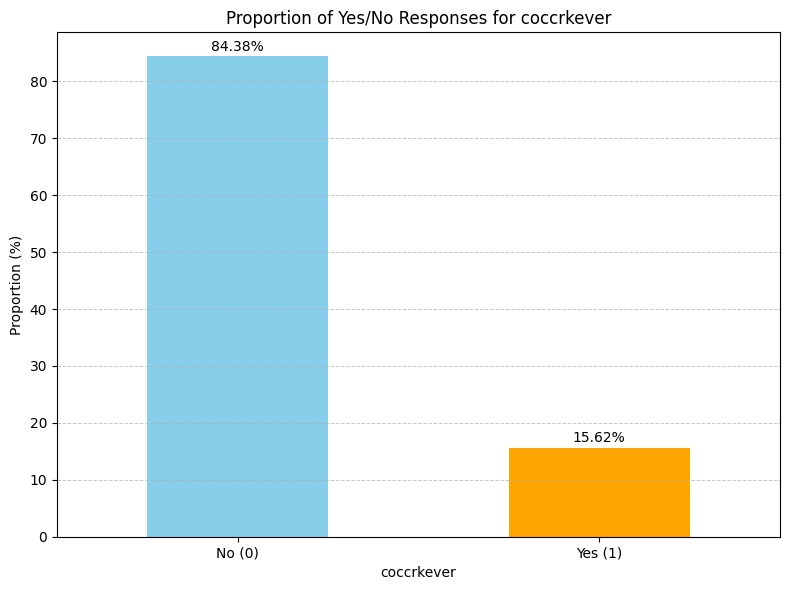

In [8]:
def proportions_of_target(input_data):
    """
    Побудова графіка пропорцій для таргетної змінної.
    Підтримує як DataFrame з колонкою 'coccrkever', так і масив або серію.

    Parameters:
    input_data (DataFrame, Series, або масив): Дані з 'coccrkever' або масив таргетної змінної.

    Returns:
    None
    """
    if isinstance(input_data, pd.DataFrame):
        if 'coccrkever' not in input_data.columns:
            raise ValueError("DataFrame must contain 'coccrkever' column.")
        target = input_data['coccrkever']
    elif isinstance(input_data, (pd.Series, np.ndarray, list)):
        target = pd.Series(input_data)
    else:
        raise TypeError("Input must be a DataFrame, Series, or array-like object.")

    # Обчислення пропорцій
    proportions = target.value_counts(normalize=True) * 100

    # Побудова графіка
    plt.figure(figsize=(8, 6))
    ax = proportions.plot(kind="bar", color=['skyblue', 'orange'])

    # Налаштування графіка
    plt.ylabel("Proportion (%)")
    plt.title("Proportion of Yes/No Responses for coccrkever")
    plt.xticks(ticks=[0, 1], labels=["No (0)", "Yes (1)"], rotation=0)
    plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

    # Відображення відсотків на кожному барі
    for i, value in enumerate(proportions):
        plt.text(i, value + 1, f"{value:.2f}%", ha="center", fontsize=10)

    plt.tight_layout()
    plt.show()

proportions_of_target(data)


In [9]:
# SMOTE для числових змінних
smote = SMOTE(sampling_strategy=1.0, random_state=42)
X_numerical = X[NUMERICAL_COLUMNS]
X_categorical = X[CATEGORICAL_COLUMNS]

# Генерація синтетичних даних для числових змінних
X_numerical_resampled, y_resampled = smote.fit_resample(X_numerical, y)

# Об'єднання синтетичних числових даних із категорійними
X = pd.concat([pd.DataFrame(X_numerical_resampled, columns=NUMERICAL_COLUMNS), 
               X_categorical.reset_index(drop=True)], axis=1)


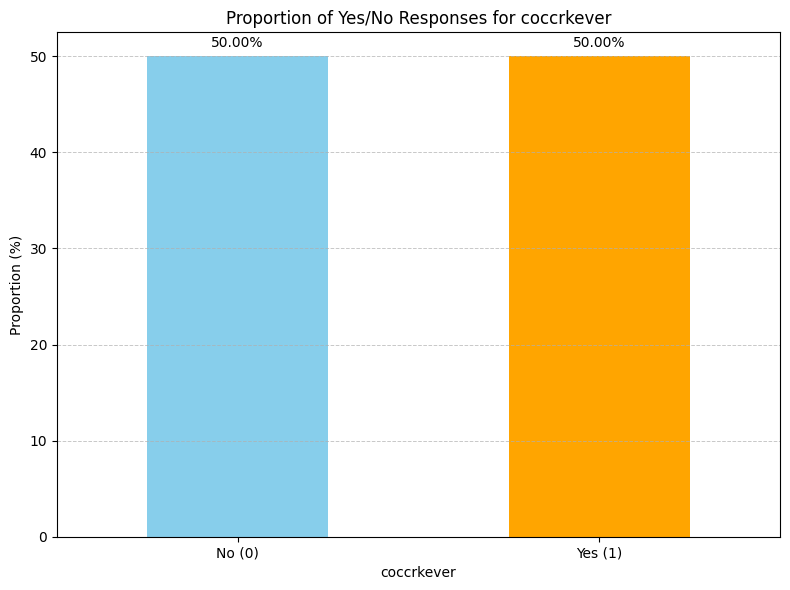

In [10]:
proportions_of_target(y_resampled)


### <span style="color:#FFD000">Створення Pipeline</span>

In [11]:
# StandardScaler() applied to NUMERICAL_COLUMNS, and OneHotEncoder() applied to CATEGORICAL_COLUMNS
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', StandardScaler(), NUMERICAL_COLUMNS),
        ('categorical', OneHotEncoder(drop='first', handle_unknown='ignore'), CATEGORICAL_COLUMNS)
    ]
)

# Define pipeline with preprocessing and placeholder for model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', 'passthrough')])
joblib.dump(pipeline, MODELS_PATH + 'pipeline_V2.pkl') # Save the pipeline


['../models/pipeline_V2.pkl']

In [12]:
# # Load the pipeline from the file
# loaded_pipeline = joblib.load(pipeline_path)
# print(f"Pipeline loaded from {pipeline_path}")

# # Example usage of the loaded pipeline
# X_transformed = loaded_pipeline['preprocessor'].transform(X_test)
# print(f"Transformed X_test shape: {X_transformed.shape}")


### <span style="color:#FFD000">Розділення даних на піднабори</span>

In [13]:
# Розділення на навчальний і тестовий набори
X_train, X_test, y_train, y_test = train_test_split(X, y_resampled, test_size=0.2, random_state=42)
print(f'Before preprocessing: \nX_train shape: {X_train.shape} | y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape} | y_test shape: {y_test.shape}')

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Виведення інформації про результати
print(f'\nAfter preprocessing:')
print(f'X_train shape: {X_train.shape} | y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape} | y_test shape: {y_test.shape}')


del X, y, X_numerical, X_categorical, X_numerical_resampled, y_resampled, data, smote
clear_memory()


Before preprocessing: 
X_train shape: (180736, 14) | y_train shape: (180736,)
X_test shape: (45184, 14) | y_test shape: (45184,)

After preprocessing:
X_train shape: (180736, 45) | y_train shape: (180736,)
X_test shape: (45184, 45) | y_test shape: (45184,)


# <span style="color:#1477d2">Models building</span>

### <span style="color:#FFD000">Cross validation definition</span>

In [14]:
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42) # Створення крос-валідаційного розбиття
# Метрики для оцінки моделі
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           }
optimized_models = {} # Результати пошуку гіперпараметрів


### <span style="color:#FFD000">Models definitions</span>

##### <span style="color:#39E75F">LightGBM model</span>

In [15]:
lgb_params = {'n_estimators': [50, 100, 200],
              'max_depth': [3, 5, 7],
              'learning_rate': [0.01, 0.1, 0.2],
              'subsample': [0.8, 1.0],
              }
lgb_model = GridSearchCV(estimator=lgb.LGBMClassifier(random_state=42),
                         param_grid=lgb_params,
                         scoring=scoring,  # Включаємо всі метрики
                         refit='precision',  # Використовуємо precision для вибору найкращої моделі
                         cv=cv,
                         verbose=1,
                         n_jobs=-1)


##### <span style="color:#39E75F">XGBoost model</span>

In [16]:
xgb_params = {'n_estimators': [50, 100, 200],
              'max_depth': [3, 5, 7],
              'learning_rate': [0.01, 0.1, 0.2],
              'colsample_bytree': [0.8, 1.0],
              }
xgb_model = GridSearchCV(estimator=xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
                         param_grid=xgb_params,
                         scoring=scoring,
                         refit='precision',
                         cv=cv,
                         verbose=1,
                         n_jobs=-1)


##### <span style="color:#39E75F">Ridge Regression model</span>

In [17]:
ridge_params = {'alpha': [0.1, 1.0, 10.0],
                'solver': ['auto', 'svd', 'cholesky']
                }
ridge_model = GridSearchCV(estimator=RidgeClassifier(random_state=42),
                           param_grid=ridge_params,
                           scoring=scoring,
                           refit='precision',
                           cv=cv,
                           verbose=1,
                           n_jobs=-1)


##### <span style="color:#39E75F">Gradient Boosting Classifier model</span>

In [18]:
gbc_params = {'n_estimators': [50, 100, 200],
              'max_depth': [3, 5, 7],
              'learning_rate': [0.01, 0.1, 0.2],
              'subsample': [0.8, 1.0]
              }
gbc_model = GridSearchCV(estimator=GradientBoostingClassifier(random_state=42),
                         param_grid=gbc_params,
                         scoring=scoring,
                         refit='precision',
                         cv=cv,
                         verbose=1,
                         n_jobs=-1)


##### <span style="color:#39E75F">Random Forest model</span>

In [19]:
rf_params = {'n_estimators': [50, 100, 200],
             'max_depth': [3, 5, None],
             'max_features': ['sqrt', 'log2', None]
             }
rf_model = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                        param_grid=rf_params,
                        scoring=scoring,
                        refit='precision',
                        cv=cv,
                        verbose=1,
                        n_jobs=-1)


##### <span style="color:#39E75F">Stacking Classifier model</span>

In [20]:
"""Ініціалізація моделі стекінгу відбувається після оптимізації моделей базового рівня"""

# stack_params = {
#     'final_estimator__alpha': [0.1, 1.0, 10.0]  # Adjust the final Ridge parameters
# }
# stack_model = GridSearchCV(estimator=StackingClassifier(
#     estimators=[
#         ('lgb', lgb_model.best_estimator_),
#         ('xgb', xgb_model.best_estimator_),
#         ('rf', rf_model.best_estimator_)
#     ],
#     final_estimator=RidgeClassifier(random_state=42)
# ),
#     param_grid=stack_params,
#     scoring=scoring,
#     refit='precision',
#     cv=cv,
#     verbose=1,
#     n_jobs=-1)

'Ініціалізація моделі стекінгу відбувається після оптимізації моделей базового рівня'

### <span style="color:#FFD000">Models training</span>

##### <span style="color:#39E75F">LightGBM model</span>

In [21]:
lgb_model.fit(X_train, y_train)
optimized_models['LightGBM'] = lgb_model.best_estimator_
print(f"Best parameters for LightGBM: {lgb_model.best_params_}")
y_pred = lgb_model.predict(X_test)

print('\n', '=' * 30)
print(f'Model:     LightGBM {lgb_model.__class__.__name__}')
print(f'Accuracy:  {accuracy_score(y_test, y_pred):.6f}')
print(f'Precision: {precision_score(y_test, y_pred):.6f}')
print(f'Recall:    {recall_score(y_test, y_pred):.6f}')
print(f'F1-Score:  {f1_score(y_test, y_pred):.6f}')
print('=' * 30)


Fitting 2 folds for each of 54 candidates, totalling 108 fits
[LightGBM] [Info] Number of positive: 90290, number of negative: 90446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2110
[LightGBM] [Info] Number of data points in the train set: 180736, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499568 -> initscore=-0.001726
[LightGBM] [Info] Start training from score -0.001726
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

##### <span style="color:#39E75F">XGBoost model</span>

In [22]:
xgb_model.fit(X_train, y_train)
optimized_models['XGBoost'] = xgb_model.best_estimator_
print(f"Best parameters for XGBoost: {xgb_model.best_params_}")
y_pred = xgb_model.predict(X_test)

print('\n', '=' * 30)
print(f'Model:     XGBoost {xgb_model.__class__.__name__}')
print(f'Accuracy:  {accuracy_score(y_test, y_pred):.6f}')
print(f'Precision: {precision_score(y_test, y_pred):.6f}')
print(f'Recall:    {recall_score(y_test, y_pred):.6f}')
print(f'F1-Score:  {f1_score(y_test, y_pred):.6f}')
print('=' * 30)


Fitting 2 folds for each of 54 candidates, totalling 108 fits


d:\KPI\Big_data_systems\Project\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:27:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}

Model:     XGBoost GridSearchCV
Accuracy:  0.909194
Precision: 0.999785
Recall:    0.819188
F1-Score:  0.900521


##### <span style="color:#39E75F">Ridge Regression model</span>

In [23]:
ridge_model.fit(X_train, y_train)
optimized_models['Ridge'] = ridge_model.best_estimator_
print(f"Best parameters for Ridge: {ridge_model.best_params_}")
y_pred = ridge_model.predict(X_test)

print('\n', '=' * 30)
print(f'Model:     Ridge Regression {ridge_model.__class__.__name__}')
print(f'Accuracy:  {accuracy_score(y_test, y_pred):.6f}')
print(f'Precision: {precision_score(y_test, y_pred):.6f}')
print(f'Recall:    {recall_score(y_test, y_pred):.6f}')
print(f'F1-Score:  {f1_score(y_test, y_pred):.6f}')
print('=' * 30)


Fitting 2 folds for each of 9 candidates, totalling 18 fits


d:\KPI\Big_data_systems\Project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
12 fits failed out of a total of 18.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "d:\KPI\Big_data_systems\Project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\KPI\Big_data_systems\Project\.venv\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\KPI\Big_data_systems\Project\.venv\Lib\site-packages\sklearn\linear_mo

Best parameters for Ridge: {'alpha': 10.0, 'solver': 'auto'}

Model:     Ridge Regression GridSearchCV
Accuracy:  0.909039
Precision: 0.999677
Recall:    0.818968
F1-Score:  0.900344


##### <span style="color:#39E75F">Gradient Boosting Classifier model</span>

In [24]:
gbc_model.fit(X_train, y_train)
optimized_models['Gradient Boosting'] = gbc_model.best_estimator_
print(f"Best parameters for Gradient Boosting: {gbc_model.best_params_}")
y_pred = gbc_model.predict(X_test)

print('\n', '=' * 30)
print(f'Model:     Gradient Boosting Classifier {gbc_model.__class__.__name__}')
print(f'Accuracy:  {accuracy_score(y_test, y_pred):.6f}')
print(f'Precision: {precision_score(y_test, y_pred):.6f}')
print(f'Recall:    {recall_score(y_test, y_pred):.6f}')
print(f'F1-Score:  {f1_score(y_test, y_pred):.6f}')
print('=' * 30)


Fitting 2 folds for each of 54 candidates, totalling 108 fits
Best parameters for Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}

Model:     Gradient Boosting Classifier GridSearchCV
Accuracy:  0.912580
Precision: 0.992683
Recall:    0.831892
F1-Score:  0.905203


##### <span style="color:#39E75F">Random Forest model</span>

In [25]:
rf_model.fit(X_train, y_train)
optimized_models['Random Forest'] = rf_model.best_estimator_
print(f"Best parameters for Random Forest: {rf_model.best_params_}")
y_pred = rf_model.predict(X_test)

print('\n', '=' * 30)
print(f'Model:     Random Forest {rf_model.__class__.__name__}')
print(f'Accuracy:  {accuracy_score(y_test, y_pred):.6f}')
print(f'Precision: {precision_score(y_test, y_pred):.6f}')
print(f'Recall:    {recall_score(y_test, y_pred):.6f}')
print(f'F1-Score:  {f1_score(y_test, y_pred):.6f}')
print('=' * 30)


Fitting 2 folds for each of 27 candidates, totalling 54 fits
Best parameters for Random Forest: {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 100}

Model:     Random Forest GridSearchCV
Accuracy:  0.908441
Precision: 1.000000
Recall:    0.817512
F1-Score:  0.899595


##### <span style="color:#39E75F">Stacking Classifier model</span>

In [26]:
stack_params = {'final_estimator__alpha': [0.1, 1.0, 10.0]  # Adjust the final Ridge parameters
                }
stack_model = GridSearchCV(estimator=StackingClassifier(estimators=[('lgb', lgb_model.best_estimator_),
                                                                    ('xgb', xgb_model.best_estimator_),
                                                                    ('rf', rf_model.best_estimator_)
                                                                    ],
                                                        final_estimator=RidgeClassifier(random_state=42)
                                                        ),
                           param_grid=stack_params,
                           scoring=scoring,
                           refit='precision',
                           cv=cv,
                           verbose=1,
                           n_jobs=-1)


In [27]:
stack_model.fit(X_train, y_train)
optimized_models['Stacking'] = stack_model.best_estimator_
print(f"Best parameters for Stacking: {stack_model.best_params_}")
y_pred = stack_model.predict(X_test)

print('\n', '=' * 30)
print(f'Model:     {stack_model.__class__.__name__}')
print(f'Accuracy:  {accuracy_score(y_test, y_pred):.6f}')
print(f'Precision: {precision_score(y_test, y_pred):.6f}')
print(f'Recall:    {recall_score(y_test, y_pred):.6f}')
print(f'F1-Score:  {f1_score(y_test, y_pred):.6f}')
print('=' * 30)


Fitting 2 folds for each of 3 candidates, totalling 6 fits
[LightGBM] [Info] Number of positive: 90290, number of negative: 90446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2110
[LightGBM] [Info] Number of data points in the train set: 180736, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499568 -> initscore=-0.001726
[LightGBM] [Info] Start training from score -0.001726
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

d:\KPI\Big_data_systems\Project\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [04:49:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 72232, number of negative: 72356
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2107
[LightGBM] [Info] Number of data points in the train set: 144588, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499571 -> initscore=-0.001715
[LightGBM] [Info] Start training from score -0.001715
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

d:\KPI\Big_data_systems\Project\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [04:49:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\KPI\Big_data_systems\Project\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [04:49:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\KPI\Big_data_systems\Project\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [04:49:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters for Stacking: {'final_estimator__alpha': 10.0}

Model:     GridSearchCV
Accuracy:  0.913221
Precision: 0.989709
Recall:    0.835730
F1-Score:  0.906225


### <span style="color:#FFD000">Models evaluation</span>

In [28]:
results = []
models = {'LightGBM': lgb_model,
          'XGBoost': xgb_model,
          'Ridge': ridge_model,
          'Gradient Boosting': gbc_model,
          'Random Forest': rf_model,
          'Stacking': stack_model}


In [29]:
for name, model in optimized_models.items():
    y_pred = model.predict(X_test)

    results.append({'Model': name,
                    'Accuracy': accuracy_score(y_test, y_pred),
                    'Precision': precision_score(y_test, y_pred),
                    'Recall': recall_score(y_test, y_pred), 
                    'F1-Score': f1_score(y_test, y_pred),
                    })

print(pd.DataFrame(results))


               Model  Accuracy  Precision    Recall  F1-Score
0           LightGBM  0.912226   0.992937  0.830966  0.904760
1            XGBoost  0.909194   0.999785  0.819188  0.900521
2              Ridge  0.909039   0.999677  0.818968  0.900344
3  Gradient Boosting  0.912580   0.992683  0.831892  0.905203
4      Random Forest  0.908441   1.000000  0.817512  0.899595
5           Stacking  0.913221   0.989709  0.835730  0.906225


### <span style="color:#FFD000">Models saving</span>

In [30]:
# Save each model in the dictionary
for model_name, model in optimized_models.items():
    model_path = os.path.join(MODELS_PATH, f"{model_name.replace(' ', '_')}_V2.pkl")
    joblib.dump(model, model_path)
    print(f"Model {model_name} saved to {model_path}")


Model LightGBM saved to ../models/LightGBM_V2.pkl
Model XGBoost saved to ../models/XGBoost_V2.pkl
Model Ridge saved to ../models/Ridge_V2.pkl
Model Gradient Boosting saved to ../models/Gradient_Boosting_V2.pkl
Model Random Forest saved to ../models/Random_Forest_V2.pkl
Model Stacking saved to ../models/Stacking_V2.pkl


In [31]:
# Save feature columns as a JSON file
column_info = {'data_columns': NUMERICAL_COLUMNS + CATEGORICAL_COLUMNS}

with open('../models/data_columns_V2.json', 'w') as f:
    json.dump(column_info, f)

del model_name, model, model_path, column_info
clear_memory()


### <span style="color:#FFD000">Visual comparison</span>

##### <span style="color:#39E75F">Accuracy, Precision, Recall, F1-Score</span>

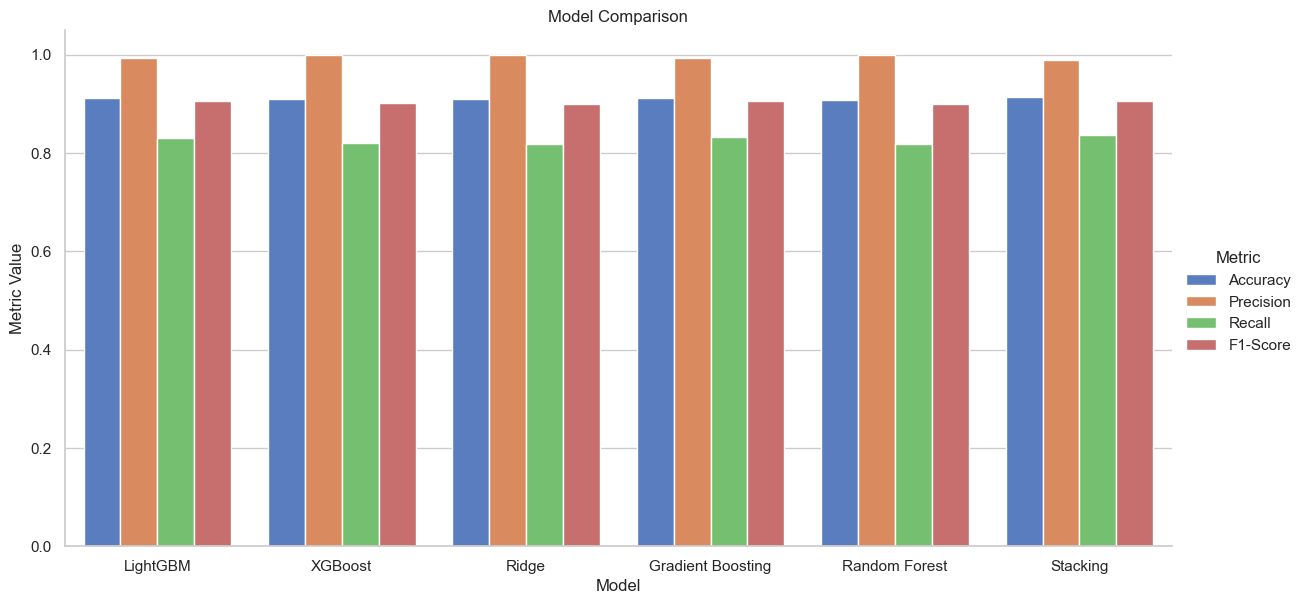

In [32]:
sns.set_theme(style="whitegrid", palette="muted")
plot = sns.catplot(data=pd.DataFrame(results).melt(id_vars="Model"), kind="bar",
                   x="Model", y="value", hue="variable", height=6, aspect=2)

plot.set_axis_labels("Model", "Metric Value")
plot.legend.set_title("Metric")
plt.title("Model Comparison")
plt.show()


##### <span style="color:#39E75F">Precision-Recall Curve, ROC Curve</span>

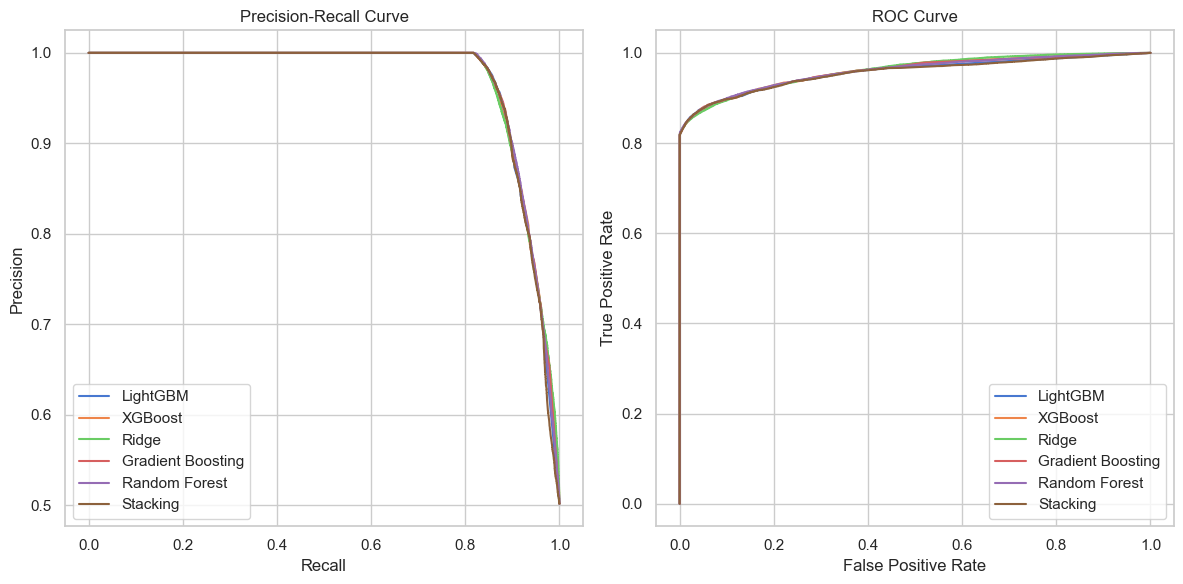

In [33]:
# Initialize the plot
plt.figure(figsize=(12, 6))

# PR Curve
plt.subplot(1, 2, 1)
for name, model in optimized_models.items():
    try:
        # Use predict_proba if available, otherwise decision_function
        if hasattr(model, "predict_proba"):
            y_scores = model.predict_proba(X_test)[:, 1]
        elif hasattr(model, "decision_function"):
            y_scores = model.decision_function(X_test)
        else:
            raise AttributeError(f"{name} does not support probabilities or decision scores.")
        
        precision, recall, _ = precision_recall_curve(y_test, y_scores)
        plt.plot(recall, precision, label=name)
    except AttributeError as e:
        print(e)

plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

# ROC Curve
plt.subplot(1, 2, 2)
for name, model in optimized_models.items():
    try:
        # Use predict_proba if available, otherwise decision_function
        if hasattr(model, "predict_proba"):
            y_scores = model.predict_proba(X_test)[:, 1]
        elif hasattr(model, "decision_function"):
            y_scores = model.decision_function(X_test)
        else:
            raise AttributeError(f"{name} does not support probabilities or decision scores.")
        
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        plt.plot(fpr, tpr, label=name)
    except AttributeError as e:
        print(e)

plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.tight_layout()
plt.show()

del fpr, tpr, precision, recall, y_scores, plot, name, model, y_pred
clear_memory()


# <span style="color:#1477d2">Outro</span>

In [34]:
elapsed_time = time.time() - START_TIMER
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)

if hours > 0:
    print(f'Elapsed time: {int(hours)} hours {int(minutes)} minutes {int(seconds)} seconds')
elif minutes > 0:
    print(f'Elapsed time: {int(minutes)} minutes {int(seconds)} seconds')
else:
    print(f'Elapsed time: {int(seconds)} seconds')
print(f'Processor:    AMD Ryzen 5 3550H with Radeon Vega')
print(f'RAM:          8.00 GB')
print(f'OS:           Windows 10 Pro')

del START_TIMER, elapsed_time, hours, remainder, minutes, seconds, f
clear_memory()


Elapsed time: 1 hours 26 minutes 24 seconds
Processor:    AMD Ryzen 5 3550H with Radeon Vega
RAM:          8.00 GB
OS:           Windows 10 Pro
